# Income dataset case study

In [1]:
# limit the number of threads used by xgboost models
import os
os.environ["OMP_NUM_THREADS"] = "8"
os.environ["OPENBLAS_NUM_THREADS"] = "8"
os.environ["MKL_NUM_THREADS"] = "8"
os.environ["VECLIB_MAXIMUM_THREADS"] = "8"
os.environ["NUMEXPR_NUM_THREADS"] = "8"

# standard libaries
import sys
import copy
import dill
from collections import defaultdict
import numpy as np
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# flow specific packages
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from flow import Node, CreditFlow, Graph, get_source_nodes, topo_sort, flatten_graph, eval_graph, boundary_graph, single_source_graph, viz_graph, save_graph, hcluster_graph
from flow import ParallelCreditFlow, GraphExplainer, translator
from flow import group_nodes, build_feature_graph
from flow import CausalLinks, create_xgboost_f
from flow import edge_credits2edge_credit, node_dict2str_dict
from on_manifold import OnManifoldExplainer, IndExplainer

np.random.seed(42) # fix for reproducibility

# Dataset

In [2]:
X,y = shap.datasets.adult()
X_display,y_display = shap.datasets.adult(display=True) # human readable feature values

xgb_full = xgboost.DMatrix(X, label=y)

# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

print(X.shape)
X_display.head()

(32561, 12)


,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,State-gov,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States
1,50.0,Self-emp-not-inc,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States
2,38.0,Private,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States
3,53.0,Private,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States
4,28.0,Private,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba


# Explanation settings

In [3]:
n_bg = 1 # number of sampled background samples
nsamples = 100 # number of fg samples to explain
nruns = 100 # paper: 10,000, number of monte carlo samplings
bg = X.fillna(X.mean()).sample(n_bg) # background samples
fg = X[:nsamples] # foreground samples to explain
sample_ind = 3 # sample to show

# Training

In [4]:
params = {
    "eta": 0.01,
    "max_depth": 4,
    'objective':'binary:logistic', # output probability
    "subsample": 0.9
}
model = xgboost.train(params, xgb_train, 3000, evals = [(xgb_test, "test")], verbose_eval=1000)

# workaround from https://github.com/slundberg/shap/issues/1215
mybooster = model

model_bytearray = mybooster.save_raw()[4:]
def myfun(self=None):
    return model_bytearray
mybooster.save_raw = myfun

[0]	test-error:0.15507
[1000]	test-error:0.12867
[2000]	test-error:0.12498
[2999]	test-error:0.12498


# Ind Shap

0it [00:00, ?it/s]


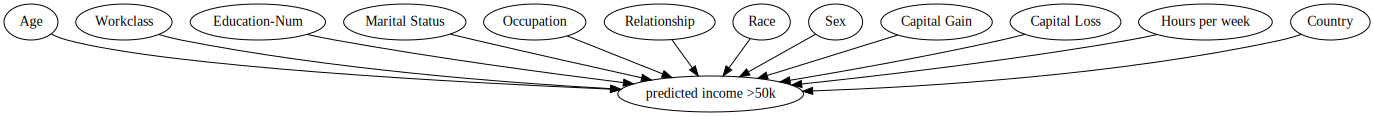

In [5]:
causal_links = CausalLinks()
categorical_feature_names = ['Workclass', 'Marital Status', 'Occupation',
                             'Relationship', 'Race', 'Sex', 'Country']
display_translator = translator(X.columns, X, X_display)
target_name = 'predicted income >50k'
feature_names = list(X.columns)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_xgboost_f(feature_names, model))
graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name)
graph.draw()

In [6]:
# multiple background result
edge_credits = [] # save for each run
for i in range(len(bg)): # average run result using linearity axiom
    print(f'bg {i}/{len(bg)}')
    explainer = GraphExplainer(graph, bg[i:i+1], nruns=nruns) 
    cf = explainer.shap_values(fg)
    edge_credits.append(node_dict2str_dict(cf.edge_credit)) # use node name is more portable vs. node

bruteforce sampling:   1%|          | 1/100 [00:00<00:10,  9.63it/s]

bg 0/1


bruteforce sampling: 100%|██████████| 100/100 [00:09<00:00, 11.08it/s]


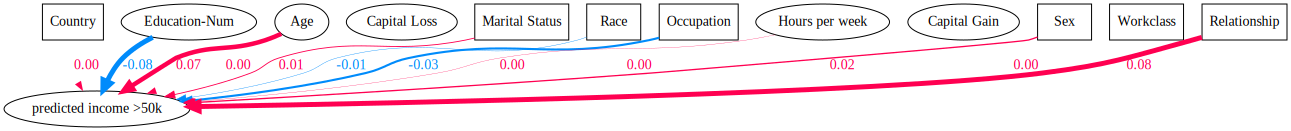

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f1928399840>>

In [7]:
cf.draw(sample_ind, max_display=10, edge_credit=edge_credits2edge_credit(edge_credits, cf.graph), show_fg_val=False)

# On manifold SHAP

In [8]:
feature_names = X.columns
f = lambda x: model.predict(xgboost.DMatrix(pd.DataFrame(x, columns=feature_names))) # wrapper for the model used by on manifold explainer

# multiple background result
manifold_edge_credits = [] # save for each run
bg_on_manifold = X.fillna(X.mean()).sample(100) # used to learn conditional dependence
for i in range(len(bg)): # average run result using linearity axiom 
    print(f'bg {i}/{len(bg)}')
    explainer = OnManifoldExplainer(f, pd.concat([bg[i:i+1], bg_on_manifold]), nruns=nruns)
    cf_on_manifold = explainer.shap_values(fg)
    manifold_edge_credits.append(cf_on_manifold) # use node name is more portable vs. node

manifold bg samples:   0%|          | 0/100 [00:00<?, ?it/s]

bg 0/1


manifold bg samples: 100%|██████████| 100/100 [13:19<00:00,  8.00s/it]


On manifold


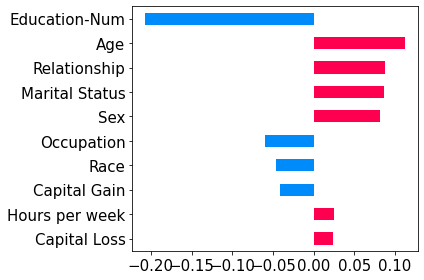

In [9]:
print('On manifold')
sum(manifold_edge_credits).draw(sample_ind, show=False, max_display=10)
plt.tight_layout()
plt.show()

# Shapley Flow

learning dependency for Education-Num: 100%|██████████| 8/8 [00:00<00:00, 89.46it/s]


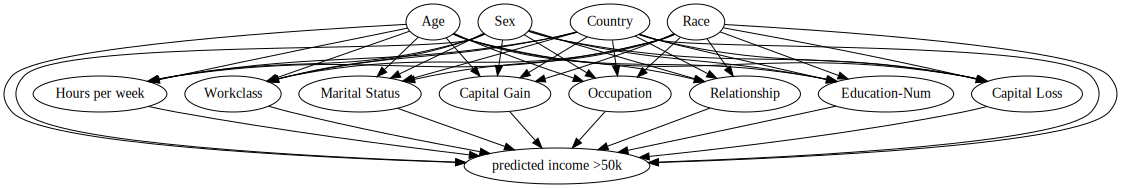

In [10]:
causal_links = CausalLinks()
categorical_feature_names = ['Workclass', 'Marital Status', 'Occupation',
                             'Relationship', 'Race', 'Sex', 'Country']
display_translator = translator(X.columns, X, X_display)
target_name = 'predicted income >50k'
feature_names = list(X.columns)

# build causal links
causal_links.add_causes_effects(feature_names, target_name, create_xgboost_f(feature_names, model)) # target is probability
A = ['Age', 'Sex', 'Country', 'Race']
D = list(set(feature_names) - set(A))
causal_links.add_causes_effects(A, D)

causal_graph = build_feature_graph(X.fillna(X.mean()), causal_links, categorical_feature_names, display_translator, target_name, method='linear')
causal_graph.draw()

In [11]:
# multiple background result
causal_edge_credits = [] # save for each run
for i in range(len(bg)): # average run result using linearity axiom
    print(f'bg {i}/{len(bg)}')
    cf_c = GraphExplainer(causal_graph, bg[i:i+1], nruns=nruns).shap_values(fg)
    causal_edge_credits.append(node_dict2str_dict(cf_c.edge_credit)) # use node name is more portable vs. node

bruteforce sampling:   0%|          | 0/100 [00:00<?, ?it/s]

bg 0/1


bruteforce sampling: 100%|██████████| 100/100 [00:31<00:00,  3.18it/s]


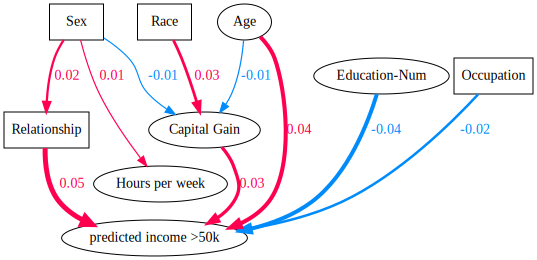

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f1872b82780>>

In [12]:
cf_c.draw(sample_ind, max_display=10, show_fg_val=False, edge_credit=edge_credits2edge_credit(causal_edge_credits, cf_c.graph))

# Methods comparison: flow, independent, on-manifold, ASV

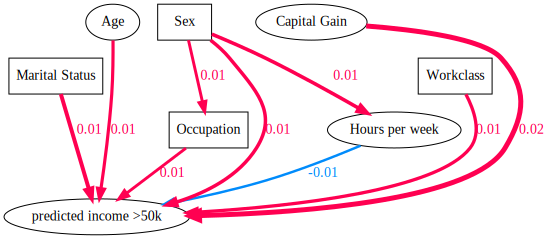

In [13]:
sample_ind = 33
cf_c.fold_noise = True
g = cf_c.draw(sample_ind, max_display=9, show_fg_val=False, edge_credit=edge_credits2edge_credit(causal_edge_credits, cf_c.graph))

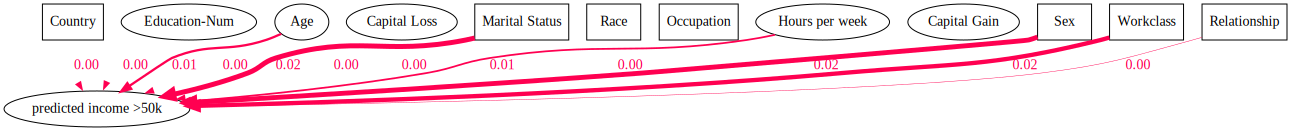

<AGraph <Swig Object of type 'Agraph_t *' at 0x7f1872b82c30>>

In [14]:
cf.draw(sample_ind, max_display=10, show_fg_val=False, edge_credit=edge_credits2edge_credit(edge_credits, cf.graph))

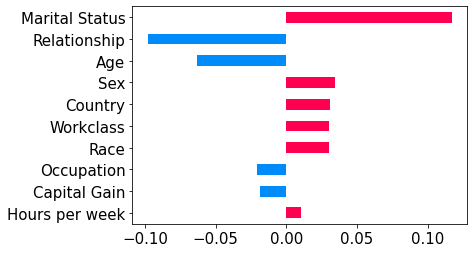

In [15]:
sum(manifold_edge_credits).draw(sample_ind, max_display=10)

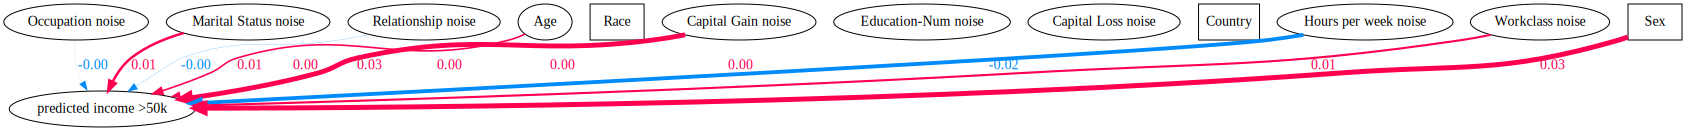

In [16]:
cf_c.fold_noise = False
g = cf_c.draw_asv(sample_ind, max_display=10, show_fg_val=False, flow_credit=edge_credits2edge_credit(causal_edge_credits, cf_c.graph))

# Investigate the background and foreground samples

In [17]:
bg_sample = bg.iloc[0]
pd.concat([X_display.iloc[bg_sample.name], X_display.iloc[sample_ind]], 1).rename(columns={bg_sample.name: "background sample", sample_ind: 'foreground sample'}).T

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
background sample,27,Private,10,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,38,United-States
foreground sample,30,Federal-gov,10,Married-civ-spouse,Adm-clerical,Own-child,White,Male,0,0,40,United-States


This example is interesting because although Capital Gain is the same between background and the foreground sample, Shapley Flow and on manifold SHAP and ASV all give non-zero attribution to it because we are modeling the relationship among input features. Whether such attribution should be warranteed is not clear. Future work should dive into the implication of such phenonmena. Moreover, note that this phenonmena only occurs in non-linear models.